In [1]:
# ============================================================
# Equity / Bond Relative Performance → Macro Regime Pipeline
#
# 阶段  内容                     目的
# 01   数据清洗与构造             构建日频 Equity/Bond 相对强弱序列
# 02   信号变换                   对数变换 + 标准化刻画长期状态
# 03   Regime 定义                基于 z-score + hysteresis 构建风险 ON/OFF
# 04   单市场回测                 验证风险调节效果（长仓过滤）
# 05   跨市场验证                 比较不同市场相对自身基准的改进
# 06   子样本稳健性               pre-2015 / post-2015 / post-2020
#
# Backtest convention:
#   position_t = regime_{t-1}  (no look-ahead)
#   strategy_ret_t = position_t * market_ret_t
# ============================================================

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Iterable, Optional, Tuple, Dict

TRADING_DAYS = 252


# ============================
# Common utils
# ============================

def _ensure_daily_series(s: pd.Series, idx: pd.DatetimeIndex) -> pd.Series:
    """Align any input series to daily index and forward-fill."""
    if not isinstance(s.index, pd.DatetimeIndex):
        raise TypeError("Series index must be DatetimeIndex.")
    return s.reindex(idx).ffill()


def zscore_rolling(x: pd.Series, window: int = 252, min_periods: Optional[int] = None) -> pd.Series:
    """Rolling z-score: (x - mean) / std."""
    if min_periods is None:
        min_periods = window
    mu = x.rolling(window, min_periods=min_periods).mean()
    sd = x.rolling(window, min_periods=min_periods).std()
    return (x - mu) / sd


def hysteresis_regime(score: pd.Series, upper: float, lower: float) -> pd.Series:
    """
    Hysteresis ON/OFF:
      - Turn ON when score > upper
      - Turn OFF when score < lower
      - Else keep previous state
    Returns int series {0,1}.
    """
    out = pd.Series(index=score.index, dtype="float64")
    state = 0
    for t, v in score.items():
        if pd.isna(v):
            out.loc[t] = np.nan
            continue
        if state == 0 and v > upper:
            state = 1
        elif state == 1 and v < lower:
            state = 0
        out.loc[t] = state
    return out.ffill().fillna(0).astype(int)


def annualized_return(daily_ret: pd.Series) -> float:
    r = daily_ret.dropna()
    if len(r) == 0:
        return np.nan
    eq = (1 + r).cumprod()
    years = len(eq) / TRADING_DAYS
    return float(eq.iloc[-1] ** (1 / years) - 1) if years > 0 else np.nan


def annualized_vol(daily_ret: pd.Series) -> float:
    r = daily_ret.dropna()
    return float(r.std() * np.sqrt(TRADING_DAYS)) if len(r) > 1 else np.nan


def sharpe_ratio(daily_ret: pd.Series) -> float:
    v = annualized_vol(daily_ret)
    if v == 0 or np.isnan(v):
        return np.nan
    return float(annualized_return(daily_ret) / v)


def max_drawdown(daily_ret: pd.Series) -> float:
    r = daily_ret.dropna()
    if len(r) == 0:
        return np.nan
    eq = (1 + r).cumprod()
    dd = eq / eq.cummax() - 1
    return float(dd.min())


def rolling_sharpe(daily_ret: pd.Series, window: int = 756) -> pd.Series:
    """Rolling Sharpe over a window (default ~3y)."""
    r = daily_ret.copy()
    mu = r.rolling(window, min_periods=window).mean() * TRADING_DAYS
    sd = r.rolling(window, min_periods=window).std() * np.sqrt(TRADING_DAYS)
    return mu / sd


# ============================
# Stage 01 — Data cleaning & construction
# ============================

def build_equity_bond_ratio(
    df: pd.DataFrame,
    equity_proxy: str,
    bond_proxy: str,
) -> pd.Series:
    """
    Construct daily Equity/Bond ratio = Equity Price / Bond Price.
    Both series must exist in df as price levels.
    """
    if equity_proxy not in df.columns:
        raise KeyError(f"equity_proxy '{equity_proxy}' not found in df.columns")
    if bond_proxy not in df.columns:
        raise KeyError(f"bond_proxy '{bond_proxy}' not found in df.columns")

    eq = df[equity_proxy].astype(float)
    bd = df[bond_proxy].astype(float)

    ratio = (eq / bd).replace([np.inf, -np.inf], np.nan)
    ratio.name = "eq_bond_ratio"
    return ratio


# ============================
# Stage 02 — Signal transform
# ============================

def build_equity_bond_score(
    ratio: pd.Series,
    z_window: int = 252,
) -> pd.Series:
    """
    Slow state = zscore(log(Equity/Bond ratio)).
    Higher => more risk-on.
    """
    x = np.log(ratio.replace(0, np.nan))
    x.name = "log_eq_bond"
    z = zscore_rolling(x, window=z_window, min_periods=z_window)
    z.name = "eq_bond_score"
    return z


# ============================
# Stage 03 — Regime definition
# ============================

def build_regime_from_score(score: pd.Series, upper: float, lower: float) -> pd.Series:
    reg = hysteresis_regime(score, upper=upper, lower=lower)
    reg.name = "regime"
    return reg


# ============================
# Stage 04 — Single-market backtest
# ============================

@dataclass
class BacktestSummary:
    market: str
    ann_ret: float
    ann_vol: float
    sharpe: float
    max_dd: float
    bh_ann_ret: float
    bh_sharpe: float
    pct_in_market: float
    sharpe_minus_bh: float


def backtest_long_only_filter(price: pd.Series, regime: pd.Series) -> Tuple[pd.DataFrame, BacktestSummary]:
    """
    Long-only risk filter backtest.
    position_t = regime_{t-1}
    """
    px = price.dropna().sort_index()
    reg = regime.reindex(px.index).ffill().fillna(0).astype(int)

    mkt_ret = px.pct_change()
    pos = reg.shift(1).fillna(0).astype(float)
    strat_ret = pos * mkt_ret

    bt = pd.DataFrame(
        {
            "price": px,
            "mkt_ret": mkt_ret,
            "regime": reg,
            "position": pos,
            "strategy_ret": strat_ret,
            "bh_ret": mkt_ret,
        }
    )

    s = BacktestSummary(
        market="",
        ann_ret=annualized_return(bt["strategy_ret"]),
        ann_vol=annualized_vol(bt["strategy_ret"]),
        sharpe=sharpe_ratio(bt["strategy_ret"]),
        max_dd=max_drawdown(bt["strategy_ret"]),
        bh_ann_ret=annualized_return(bt["bh_ret"]),
        bh_sharpe=sharpe_ratio(bt["bh_ret"]),
        pct_in_market=float(bt["position"].mean()),
        sharpe_minus_bh=np.nan,
    )
    s.sharpe_minus_bh = float(s.sharpe - s.bh_sharpe) if (not np.isnan(s.sharpe) and not np.isnan(s.bh_sharpe)) else np.nan

    return bt, s


def plot_market_diagnostics(
    bt: pd.DataFrame,
    title: str,
    roll_window: int = 756,
    show_rolling_sharpe: bool = True,
):
    bt = bt.dropna(subset=["strategy_ret", "bh_ret"]).copy()

    eq_strat = (1 + bt["strategy_ret"]).cumprod()
    eq_bh = (1 + bt["bh_ret"]).cumprod()

    plt.figure(figsize=(12, 4))
    plt.plot(eq_strat.index, eq_strat.values, label="Strategy (Regime Filter)")
    plt.plot(eq_bh.index, eq_bh.values, label="Buy & Hold")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Regime shading on price
    plt.figure(figsize=(12, 4))
    plt.plot(bt.index, bt["price"], label="Price")

    reg = bt["regime"].astype(int)
    in_on = False
    start = None
    for t, r in reg.items():
        if (not in_on) and r == 1:
            in_on = True
            start = t
        elif in_on and r == 0:
            plt.axvspan(start, t, alpha=0.12)
            in_on = False
    if in_on:
        plt.axvspan(start, bt.index[-1], alpha=0.12)

    plt.title(f"{title} — Regime ON shaded")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if show_rolling_sharpe:
        rs = rolling_sharpe(bt["strategy_ret"], window=roll_window)
        rb = rolling_sharpe(bt["bh_ret"], window=roll_window)

        plt.figure(figsize=(12, 4))
        plt.plot(rs.index, rs.values, label=f"Strategy Rolling Sharpe ({roll_window}d)")
        plt.plot(rb.index, rb.values, label=f"BH Rolling Sharpe ({roll_window}d)")
        plt.axhline(0, linestyle=":", linewidth=1)
        plt.title(f"{title} — Rolling Sharpe")
        plt.legend()
        plt.tight_layout()
        plt.show()


# ============================
# Stage 05 — Cross-market evaluation
# ============================

def run_cross_market(
    df: pd.DataFrame,
    markets: Iterable[str],
    regime: pd.Series,
    plot: bool = False,
    plot_market: Optional[str] = None,
) -> pd.DataFrame:
    rows = []
    for m in markets:
        if m not in df.columns:
            continue
        bt, s = backtest_long_only_filter(df[m], regime)
        s.market = m
        rows.append(s.__dict__)

        if plot and (plot_market is None or m == plot_market):
            plot_market_diagnostics(bt, title=f"{m} — Equity/Bond Regime Filter")

    out = pd.DataFrame(rows)
    return out


# ============================
# Stage 06 — Subsample robustness
# ============================

def _slice(df: pd.DataFrame, start: Optional[str], end: Optional[str]) -> pd.DataFrame:
    d = df.copy()
    if start is not None:
        d = d[d.index >= pd.to_datetime(start)]
    if end is not None:
        d = d[d.index <= pd.to_datetime(end)]
    return d


def run_subsample_robustness(
    df: pd.DataFrame,
    markets: Iterable[str],
    equity_proxy: str,
    bond_proxy: str,
    z_window: int,
    upper: float,
    lower: float,
    periods: Optional[Dict[str, Tuple[Optional[str], Optional[str]]]] = None,
) -> pd.DataFrame:
    if periods is None:
        periods = {
            "pre_2015": (None, "2014-12-31"),
            "post_2015": ("2015-01-01", None),
            "post_2020": ("2020-01-01", None),
        }

    all_rows = []
    for pname, (start, end) in periods.items():
        d = _slice(df, start, end)
        if d.empty:
            continue

        # rebuild regime inside subperiod to avoid look-ahead via zscore stats
        ratio = build_equity_bond_ratio(d, equity_proxy=equity_proxy, bond_proxy=bond_proxy)
        score = build_equity_bond_score(ratio, z_window=z_window)
        regime = build_regime_from_score(score, upper=upper, lower=lower)

        summ = run_cross_market(d, markets, regime, plot=False)
        if not summ.empty:
            summ.insert(0, "period", pname)
            all_rows.append(summ)

    return pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()


# ============================================================
# Pipeline runner (01–06)
# ============================================================

def run_equity_bond_regime_pipeline(
    df: pd.DataFrame,
    markets: Iterable[str],
    equity_proxy: str,
    bond_proxy: str,
    *,
    z_window: int = 252,
    upper: float = 0.5,
    lower: float = -0.5,
    plot: bool = True,
    plot_market: Optional[str] = None,
) -> Dict[str, pd.DataFrame]:
    """
    Returns:
      {
        "summary_full": DataFrame,
        "summary_subsample": DataFrame,
      }
    """

    # 01) construct ratio
    ratio = build_equity_bond_ratio(df, equity_proxy=equity_proxy, bond_proxy=bond_proxy)

    # 02) transform -> score
    score = build_equity_bond_score(ratio, z_window=z_window)

    # 03) hysteresis regime
    regime = build_regime_from_score(score, upper=upper, lower=lower)

    # 04/05) cross-market backtest + optional plots
    summary_full = run_cross_market(df, markets, regime, plot=plot, plot_market=plot_market)

    # 06) subsample robustness
    summary_subsample = run_subsample_robustness(
        df,
        markets,
        equity_proxy=equity_proxy,
        bond_proxy=bond_proxy,
        z_window=z_window,
        upper=upper,
        lower=lower,
    )

    return {
        "summary_full": summary_full,
        "summary_subsample": summary_subsample,
    }

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_28355/4074973557.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(markets, start_date, end_date)['Close'].dropna()
[*********************100%***********************]  6 of 6 completed


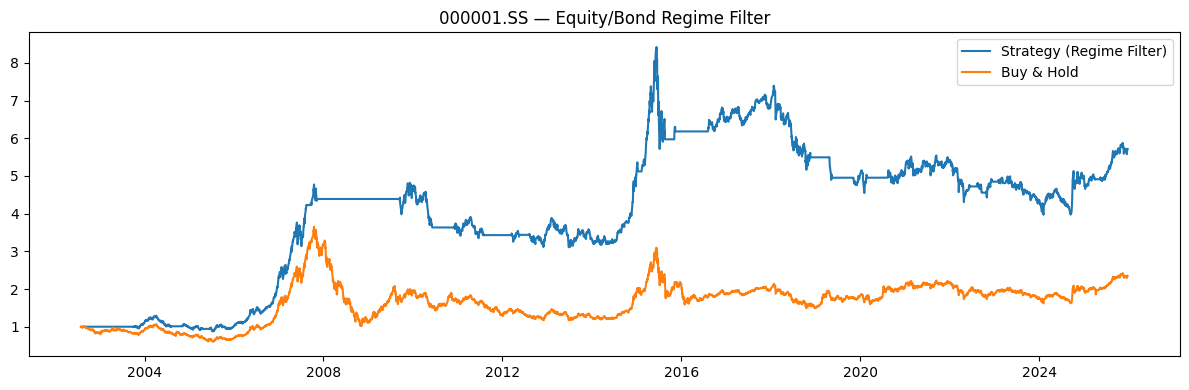

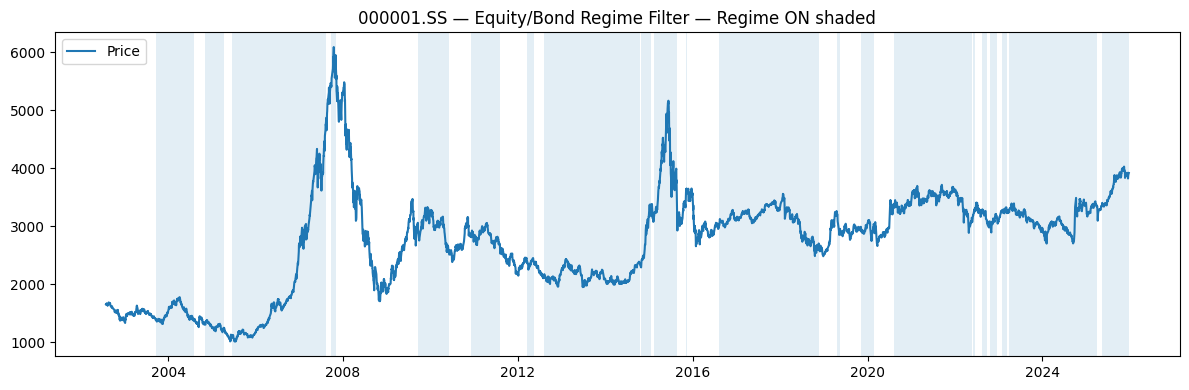

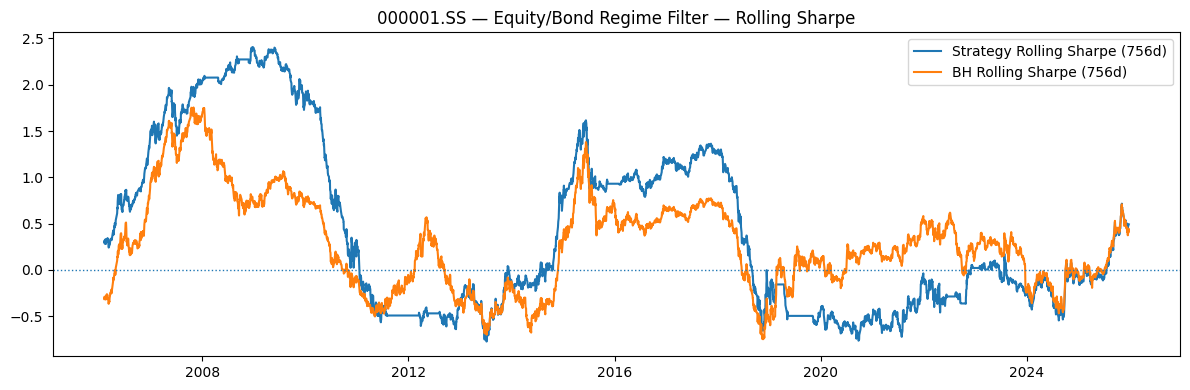

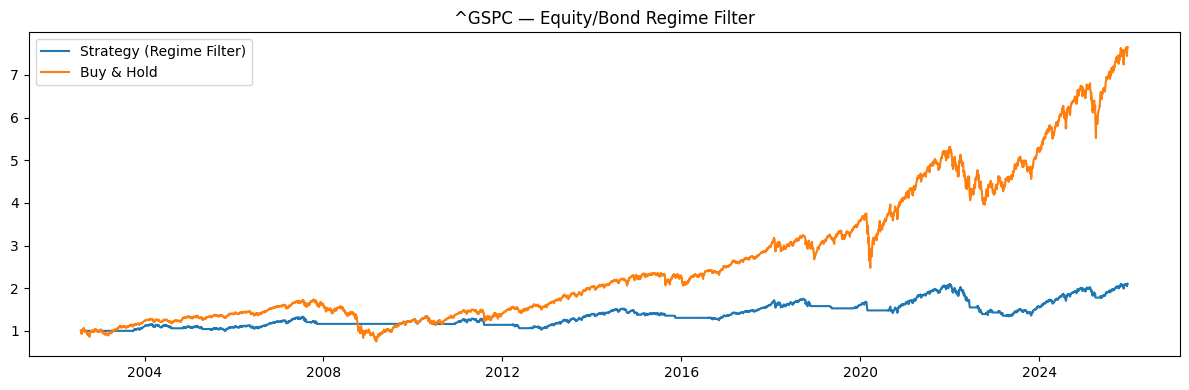

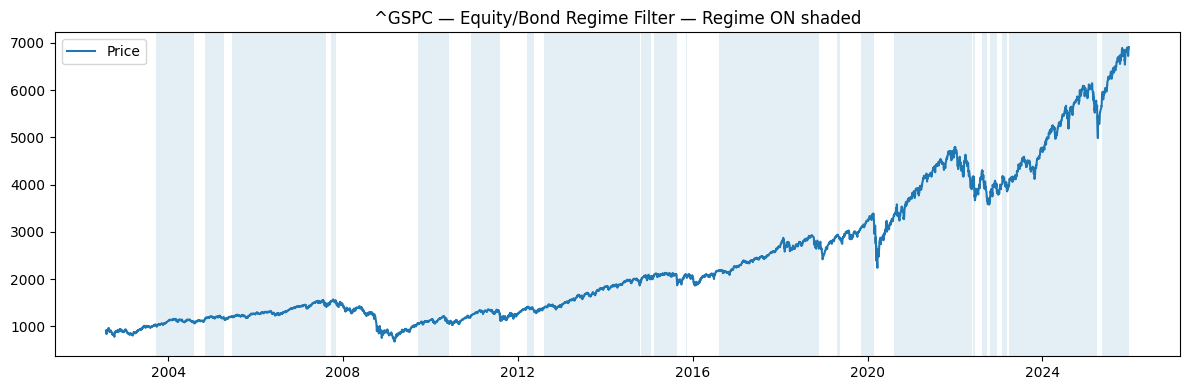

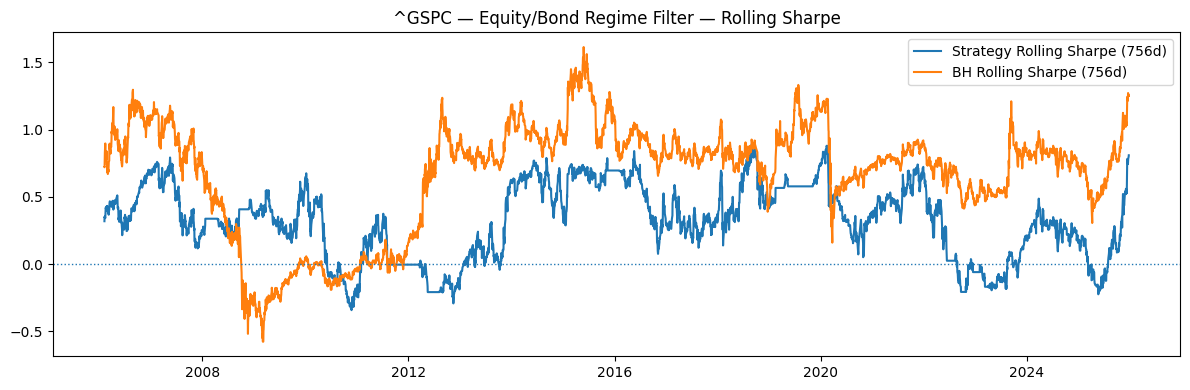

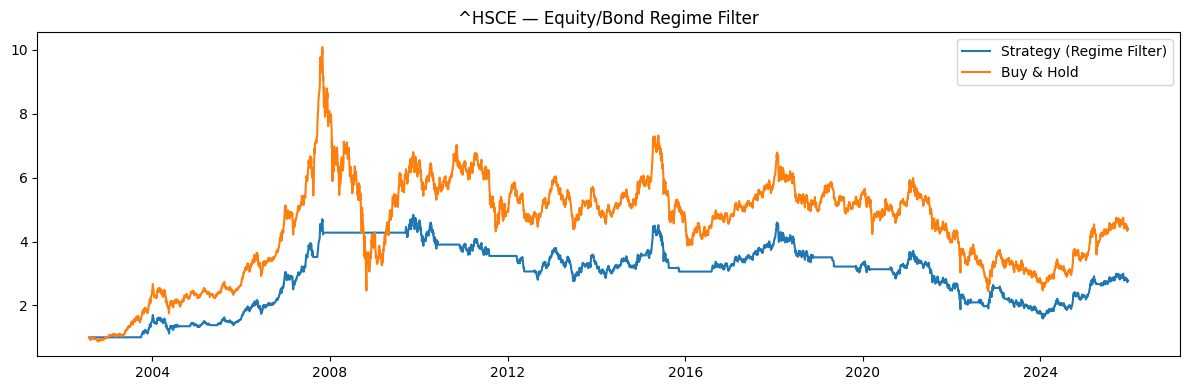

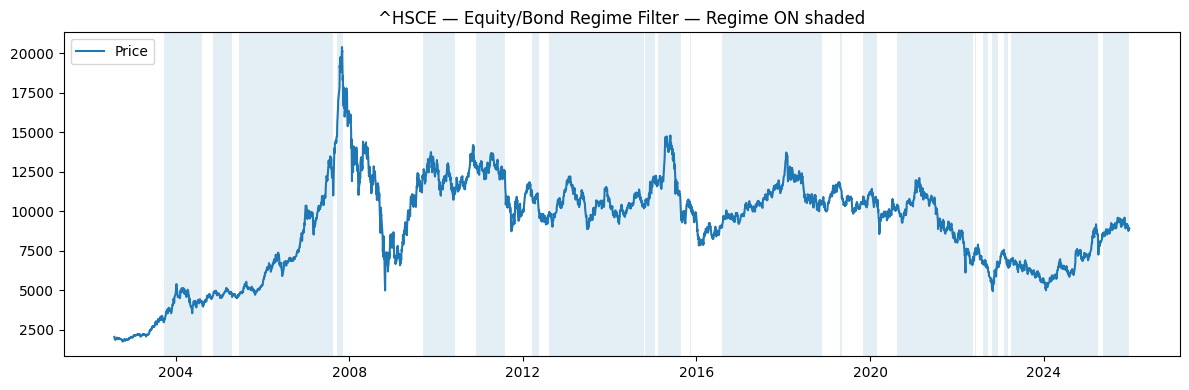

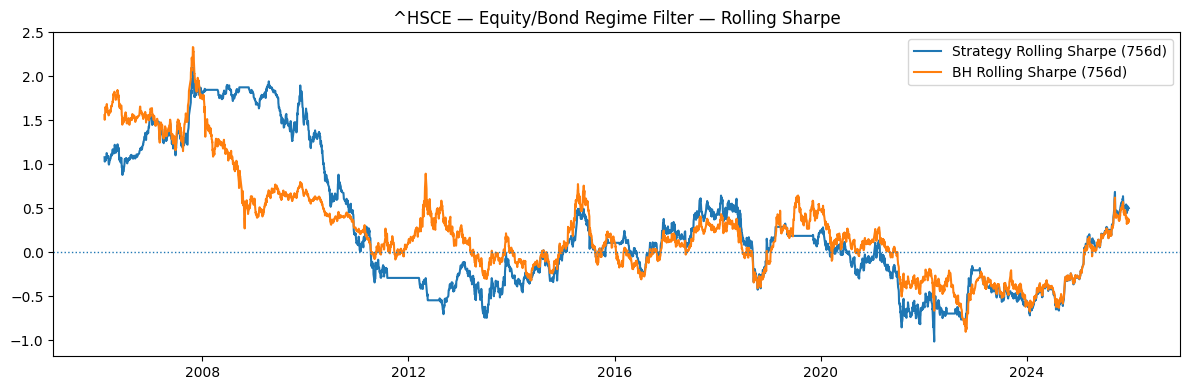

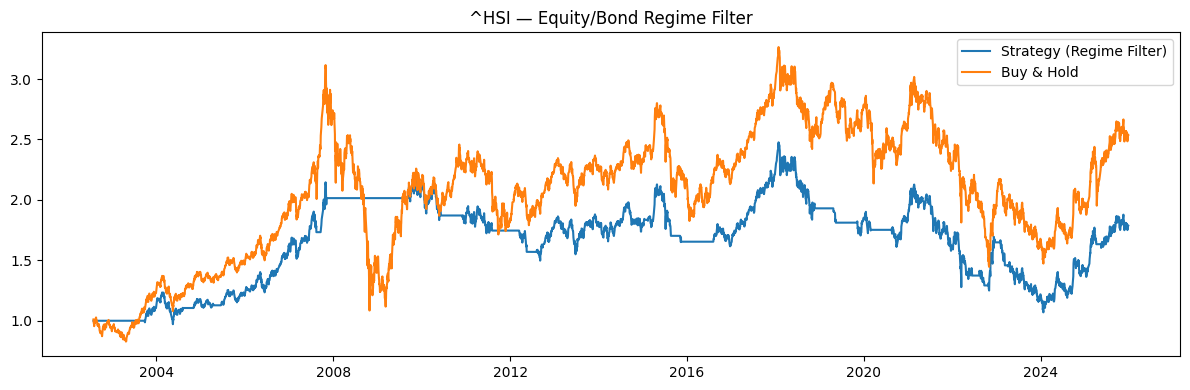

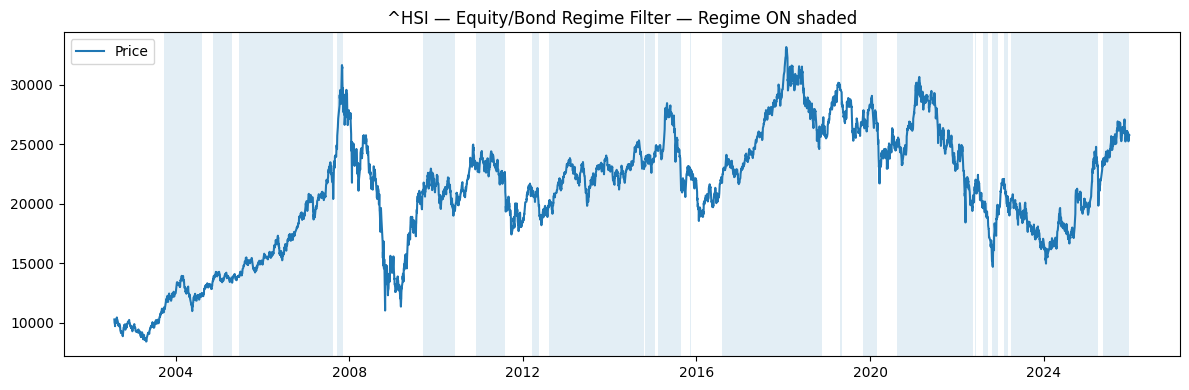

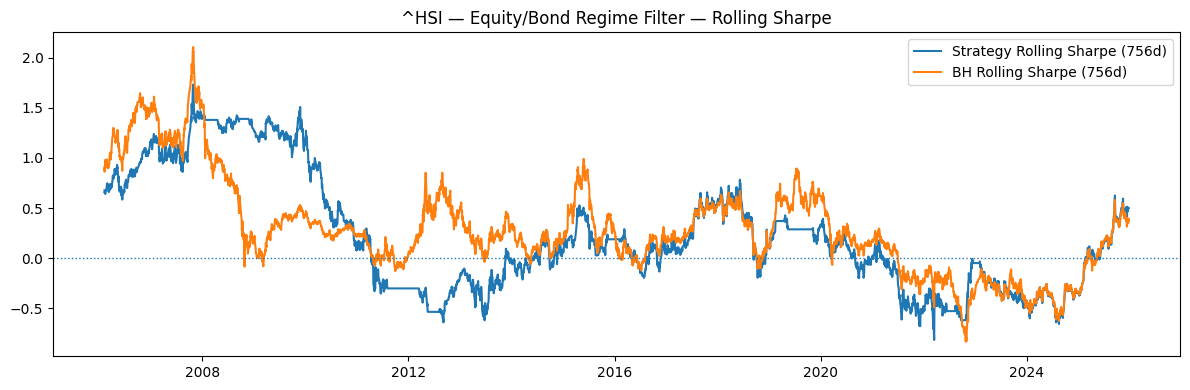

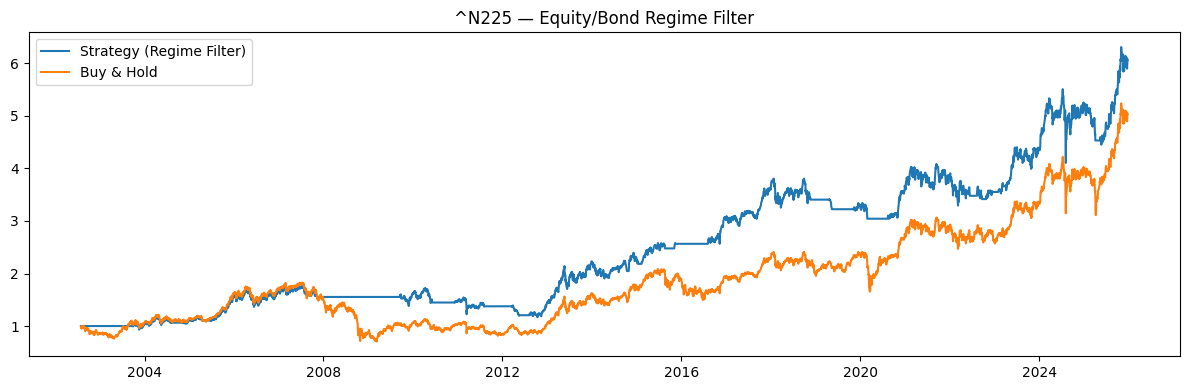

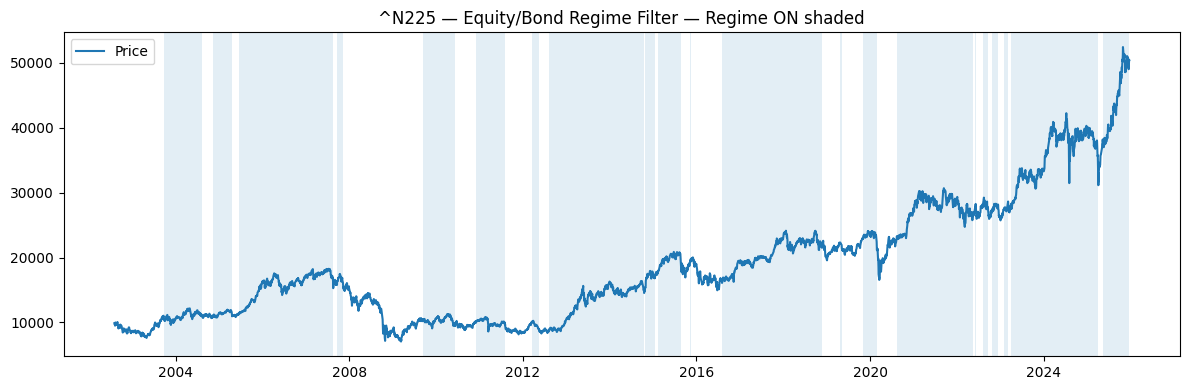

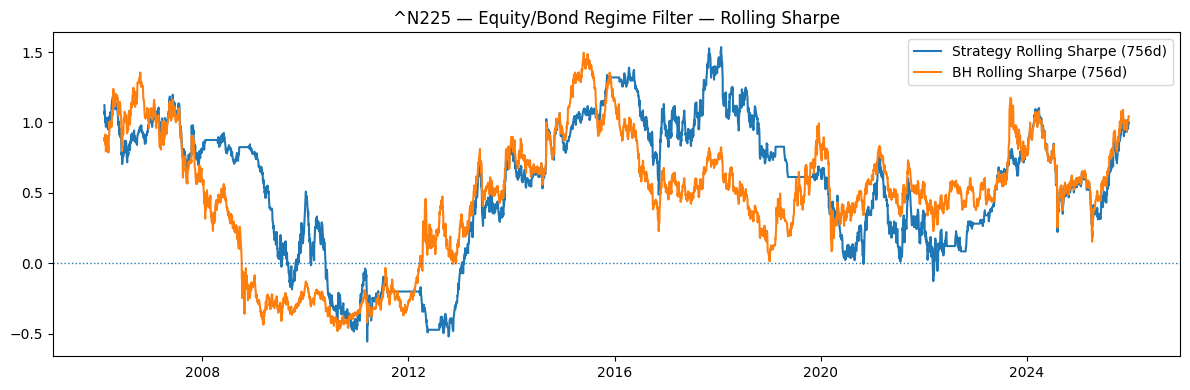

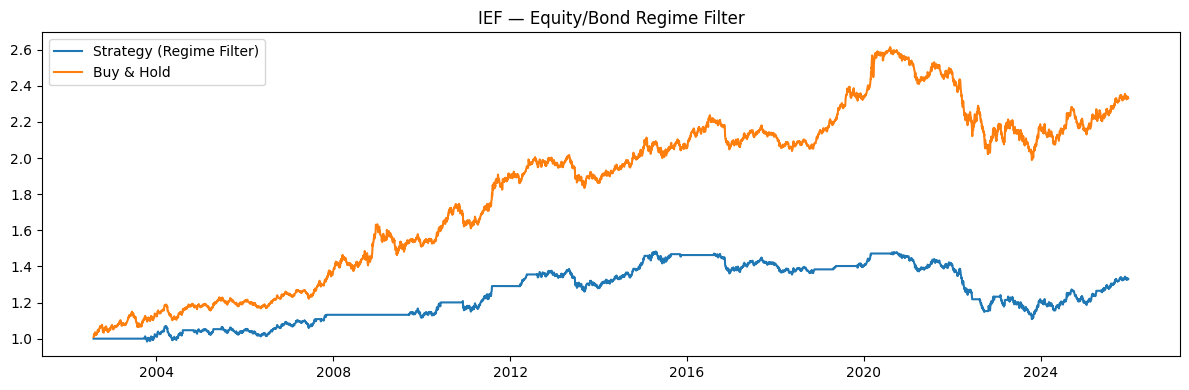

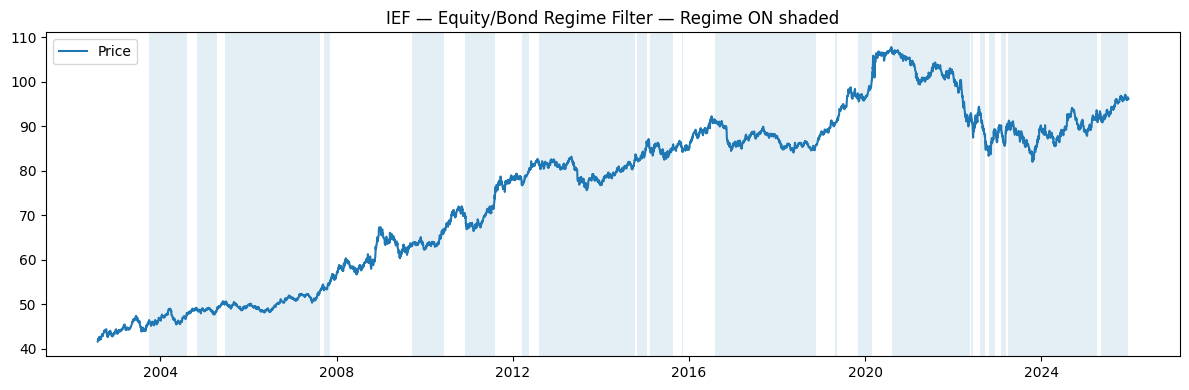

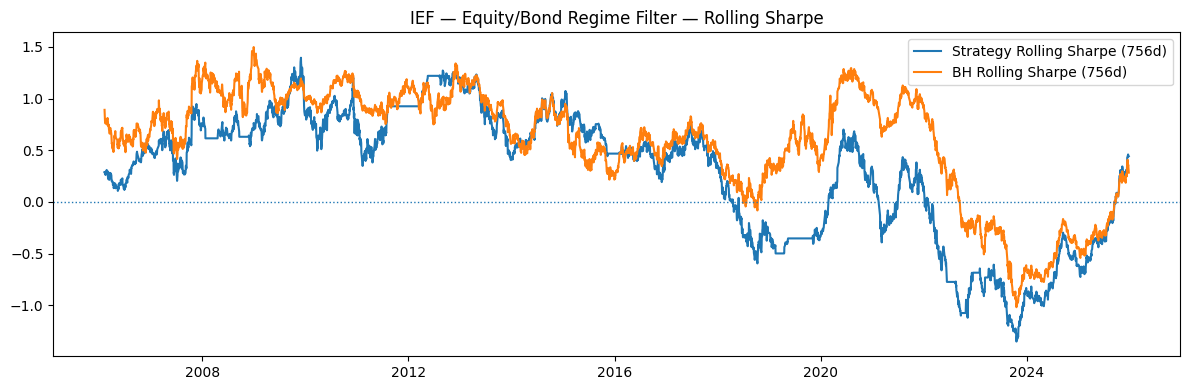

=== Full period summary ===
      market    sharpe  bh_sharpe  sharpe_minus_bh    max_dd  pct_in_market
0  000001.SS  0.505497   0.175179         0.330318 -0.528284       0.664826
4      ^N225  0.554770   0.341985         0.212785 -0.333010       0.664826
2      ^HSCE  0.246666   0.249216        -0.002550 -0.672335       0.664826
3       ^HSI  0.178716   0.193150        -0.014435 -0.568100       0.664826
1      ^GSPC  0.325886   0.526707        -0.200822 -0.362412       0.664826
5        IEF  0.269039   0.586820        -0.317781 -0.252679       0.664826

=== Subsample robustness ===
       period     market    sharpe  bh_sharpe  sharpe_minus_bh    max_dd  \
6   post_2015  000001.SS -0.060430   0.078068        -0.138497 -0.462634   
11  post_2015        IEF -0.183142   0.193649        -0.376791 -0.250726   
7   post_2015      ^GSPC  0.415843   0.739998        -0.324155 -0.362412   
8   post_2015      ^HSCE -0.048709  -0.126543         0.077834 -0.654975   
9   post_2015       ^HSI  0.04

In [7]:
import yfinance as yf

# ============================================================
# Example usage (edit here)
# ============================================================

# df: daily dataframe with prices for:
#   - your target markets (e.g. '^HSI','^GSPC','SS001','^HSCE','^N225')
#   - equity_proxy (e.g. '^GSPC' or 'SPY')
#   - bond_proxy (e.g. 'IEF' or 'TLT' or your UST index proxy)
#

markets = ['000001.SS','^GSPC','^HSCE','^HSI','^N225', 'IEF']
start_date = '2000-01-01'
end_date = '2025-12-24'

df = yf.download(markets, start_date, end_date)['Close'].dropna()
equity_proxy = '^GSPC'
bond_proxy = 'IEF'

outputs = run_equity_bond_regime_pipeline(
    df=df,
    markets=markets,
    equity_proxy=equity_proxy,
    bond_proxy=bond_proxy,
    z_window=252,
    upper=0.5,
    lower=-0.5,
    plot=True,
    plot_market=None,   # set None to plot all markets
)

print("=== Full period summary ===")
print(outputs["summary_full"][["market","sharpe","bh_sharpe","sharpe_minus_bh","max_dd","pct_in_market"]]
      .sort_values("sharpe_minus_bh", ascending=False))

print("\n=== Subsample robustness ===")
print(outputs["summary_subsample"][["period","market","sharpe","bh_sharpe","sharpe_minus_bh","max_dd","pct_in_market"]]
      .sort_values(["period","market","sharpe_minus_bh"], ascending=[True, True, False]))



In [20]:
# ============================================================
# FULL WORKING CODE — HY & IG Credit Spread Regime (01–06)
#
# 阶段  内容                     目的
# 01   数据清洗与构造             将 HY / IG 信用利差对齐到日频
# 02   信号变换                   rolling z-score + 方向统一（inversion）
# 03   Regime 定义                hysteresis 构建风险 ON / OFF
# 04   单市场回测                 长仓过滤：position_t = regime_{t-1}
# 05   跨市场验证                 以“相对自身 BH”的 Sharpe 改进为准
# 06   子样本稳健性               pre-2015 / post-2015 / post-2020（子样本内重估 z）
#
# Preconditions:
# - df: pd.DataFrame, daily DateTimeIndex, columns contain market price series
# - markets: list[str], subset of df.columns
# - hy_spread, ig_spread: pd.Series (monthly or daily), DatetimeIndex
#
# Notes:
# - FRED typical series:
#     HY OAS:  BAMLH0A0HYM2
#     BBB OAS: BAMLC0A4CBBB  (IG proxy)
# - Spread high => risk-off. We invert z-score so higher score => risk-on.
# ============================================================

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Iterable, Optional, Tuple, Dict, List

TRADING_DAYS = 252


# ============================
# Stage 01 — Data cleaning & construction
# ============================

def align_to_daily_ffill(series: pd.Series, daily_index: pd.DatetimeIndex, name: str) -> pd.Series:
    """
    Align monthly/weekly/daily series to daily index and forward fill.
    """
    if not isinstance(series.index, pd.DatetimeIndex):
        raise TypeError(f"{name} must have a DatetimeIndex.")
    s = series.sort_index().copy()
    s = s.reindex(daily_index).ffill()
    s = s.replace([np.inf, -np.inf], np.nan)
    s.name = name
    return s


# ============================
# Stage 02 — Signal transform
# ============================

def rolling_zscore(x: pd.Series, window: int = 252, min_periods: Optional[int] = None) -> pd.Series:
    """
    Rolling z-score: (x - rolling_mean) / rolling_std
    """
    if min_periods is None:
        min_periods = window
    mu = x.rolling(window, min_periods=min_periods).mean()
    sd = x.rolling(window, min_periods=min_periods).std()
    return (x - mu) / sd


def build_credit_score(spread_daily: pd.Series, z_window: int = 252) -> pd.Series:
    """
    Credit score (higher = risk-on):
      score = - zscore(spread)
    """
    z = rolling_zscore(spread_daily, window=z_window, min_periods=z_window)
    score = -z
    score.name = f"{spread_daily.name}_score"
    return score


# ============================
# Stage 03 — Regime definition (hysteresis)
# ============================

def hysteresis_regime(score: pd.Series, upper: float, lower: float) -> pd.Series:
    """
    Hysteresis ON/OFF:
      - Turn ON when score > upper
      - Turn OFF when score < lower
      - Otherwise hold previous state
    Returns int series {0,1}.
    """
    out = pd.Series(index=score.index, dtype="float64")
    state = 0
    for t, v in score.items():
        if pd.isna(v):
            out.loc[t] = np.nan
            continue
        if state == 0 and v > upper:
            state = 1
        elif state == 1 and v < lower:
            state = 0
        out.loc[t] = state
    return out.ffill().fillna(0).astype(int)


# ============================
# Stage 04 — Single-market backtest (long-only filter)
# ============================

@dataclass
class BacktestSummary:
    market: str
    ann_ret: float
    ann_vol: float
    sharpe: float
    max_dd: float
    bh_ann_ret: float
    bh_sharpe: float
    pct_in_market: float
    sharpe_minus_bh: float


def annualized_return(daily_ret: pd.Series) -> float:
    r = daily_ret.dropna()
    if len(r) == 0:
        return np.nan
    eq = (1.0 + r).cumprod()
    years = len(eq) / TRADING_DAYS
    return float(eq.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else np.nan


def annualized_vol(daily_ret: pd.Series) -> float:
    r = daily_ret.dropna()
    return float(r.std() * np.sqrt(TRADING_DAYS)) if len(r) > 1 else np.nan


def sharpe_ratio(daily_ret: pd.Series) -> float:
    v = annualized_vol(daily_ret)
    if v == 0 or np.isnan(v):
        return np.nan
    return float(annualized_return(daily_ret) / v)


def max_drawdown(daily_ret: pd.Series) -> float:
    r = daily_ret.dropna()
    if len(r) == 0:
        return np.nan
    eq = (1.0 + r).cumprod()
    dd = eq / eq.cummax() - 1.0
    return float(dd.min())


def backtest_long_only_filter(price: pd.Series, regime: pd.Series) -> Tuple[pd.DataFrame, BacktestSummary]:
    """
    Long-only regime filter:
      position_t = regime_{t-1}
      strategy_ret_t = position_t * market_ret_t
    """
    px = price.dropna().sort_index()
    reg = regime.reindex(px.index).ffill().fillna(0).astype(int)

    mkt_ret = px.pct_change()
    pos = reg.shift(1).fillna(0).astype(float)
    strat_ret = pos * mkt_ret

    bt = pd.DataFrame(
        {
            "price": px,
            "mkt_ret": mkt_ret,
            "regime": reg,
            "position": pos,
            "strategy_ret": strat_ret,
            "bh_ret": mkt_ret,
        }
    )

    s = BacktestSummary(
        market="",
        ann_ret=annualized_return(bt["strategy_ret"]),
        ann_vol=annualized_vol(bt["strategy_ret"]),
        sharpe=sharpe_ratio(bt["strategy_ret"]),
        max_dd=max_drawdown(bt["strategy_ret"]),
        bh_ann_ret=annualized_return(bt["bh_ret"]),
        bh_sharpe=sharpe_ratio(bt["bh_ret"]),
        pct_in_market=float(bt["position"].mean()),
        sharpe_minus_bh=np.nan,
    )
    s.sharpe_minus_bh = float(s.sharpe - s.bh_sharpe) if (not np.isnan(s.sharpe) and not np.isnan(s.bh_sharpe)) else np.nan

    return bt, s


def plot_equity_curve(bt: pd.DataFrame, title: str):
    bt = bt.dropna(subset=["strategy_ret", "bh_ret"]).copy()
    eq_strat = (1.0 + bt["strategy_ret"]).cumprod()
    eq_bh = (1.0 + bt["bh_ret"]).cumprod()

    plt.figure(figsize=(12, 4))
    plt.plot(eq_strat.index, eq_strat.values, label="Strategy (Regime Filter)")
    plt.plot(eq_bh.index, eq_bh.values, label="Buy & Hold")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================
# Stage 05 — Cross-market validation
# ============================

def run_cross_market(df: pd.DataFrame, markets: Iterable[str], regime: pd.Series, plot: bool = False) -> pd.DataFrame:
    rows = []
    for m in markets:
        if m not in df.columns:
            continue
        bt, s = backtest_long_only_filter(df[m], regime)
        s.market = m
        rows.append(s.__dict__)
        if plot:
            plot_equity_curve(bt, title=f"{m} — Regime Filter vs BH")
    return pd.DataFrame(rows)


# ============================
# Stage 06 — Subsample robustness
# ============================

def slice_df(df: pd.DataFrame, start: Optional[str], end: Optional[str]) -> pd.DataFrame:
    d = df.copy()
    if start is not None:
        d = d[d.index >= pd.to_datetime(start)]
    if end is not None:
        d = d[d.index <= pd.to_datetime(end)]
    return d


def run_subsample_robustness(
    df: pd.DataFrame,
    markets: Iterable[str],
    spread: pd.Series,
    *,
    spread_name: str,
    z_window: int,
    upper: float,
    lower: float,
    periods: Optional[Dict[str, Tuple[Optional[str], Optional[str]]]] = None,
) -> pd.DataFrame:
    if periods is None:
        periods = {
            "pre_2015": (None, "2014-12-31"),
            "post_2015": ("2015-01-01", None),
            "post_2020": ("2020-01-01", None),
        }

    all_rows = []
    for pname, (start, end) in periods.items():
        d = slice_df(df, start, end)
        if d.empty:
            continue

        # IMPORTANT: rebuild score/regime inside subperiod (avoid leakage via z stats)
        spread_daily = align_to_daily_ffill(spread, d.index, name=spread_name)
        score = build_credit_score(spread_daily, z_window=z_window)
        regime = hysteresis_regime(score, upper=upper, lower=lower)

        summ = run_cross_market(d, markets, regime, plot=False)
        if not summ.empty:
            summ.insert(0, "period", pname)
            summ.insert(1, "spread", spread_name)
            all_rows.append(summ)

    return pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()


# ============================================================
# Full runner for HY + IG
# ============================================================

def run_hy_ig_credit_regime_tests(
    df: pd.DataFrame,
    markets: List[str],
    hy_spread: pd.Series,
    ig_spread: pd.Series,
    *,
    z_window: int = 252,
    upper: float = 0.5,
    lower: float = -0.5,
    plot: bool = False,
) -> Dict[str, pd.DataFrame]:
    """
    Returns dict with:
      - HY_full, IG_full: full-period cross-market summary
      - HY_sub,  IG_sub : subsample robustness summary
    """

    # ----- HY full period -----
    hy_daily = align_to_daily_ffill(hy_spread, df.index, name="HY_OAS")
    hy_score = build_credit_score(hy_daily, z_window=z_window)
    hy_regime = hysteresis_regime(hy_score, upper=upper, lower=lower)
    hy_full = run_cross_market(df, markets, hy_regime, plot=plot)
    if not hy_full.empty:
        hy_full.insert(0, "spread", "HY_OAS")

    # ----- IG (BBB) full period -----
    ig_daily = align_to_daily_ffill(ig_spread, df.index, name="IG_BBB_OAS")
    ig_score = build_credit_score(ig_daily, z_window=z_window)
    ig_regime = hysteresis_regime(ig_score, upper=upper, lower=lower)
    ig_full = run_cross_market(df, markets, ig_regime, plot=plot)
    if not ig_full.empty:
        ig_full.insert(0, "spread", "IG_BBB_OAS")

    # ----- Subsamples -----
    hy_sub = run_subsample_robustness(
        df, markets, hy_spread,
        spread_name="HY_OAS",
        z_window=z_window, upper=upper, lower=lower
    )
    ig_sub = run_subsample_robustness(
        df, markets, ig_spread,
        spread_name="IG_BBB_OAS",
        z_window=z_window, upper=upper, lower=lower
    )

    return {
        "HY_full": hy_full,
        "IG_full": ig_full,
        "HY_sub": hy_sub,
        "IG_sub": ig_sub,
    }

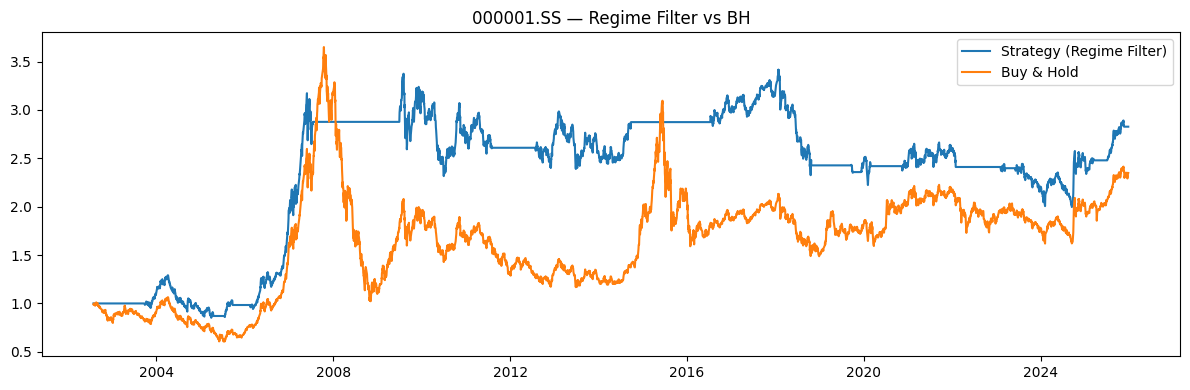

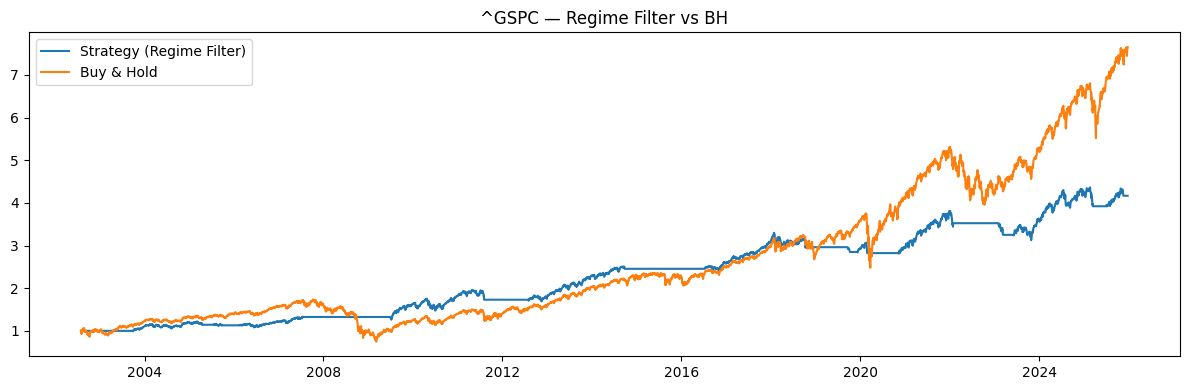

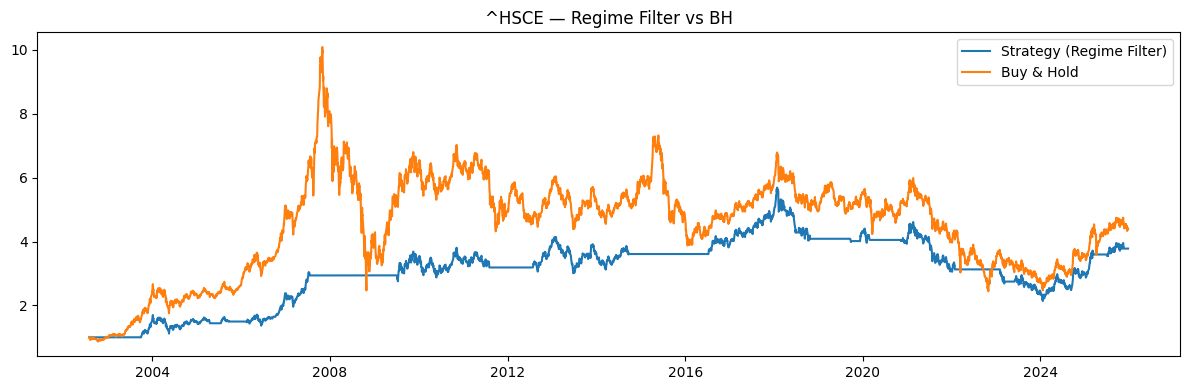

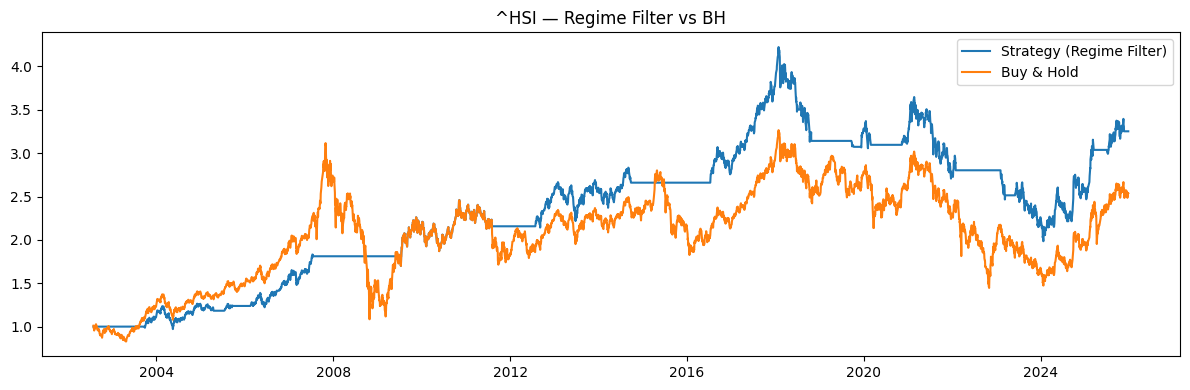

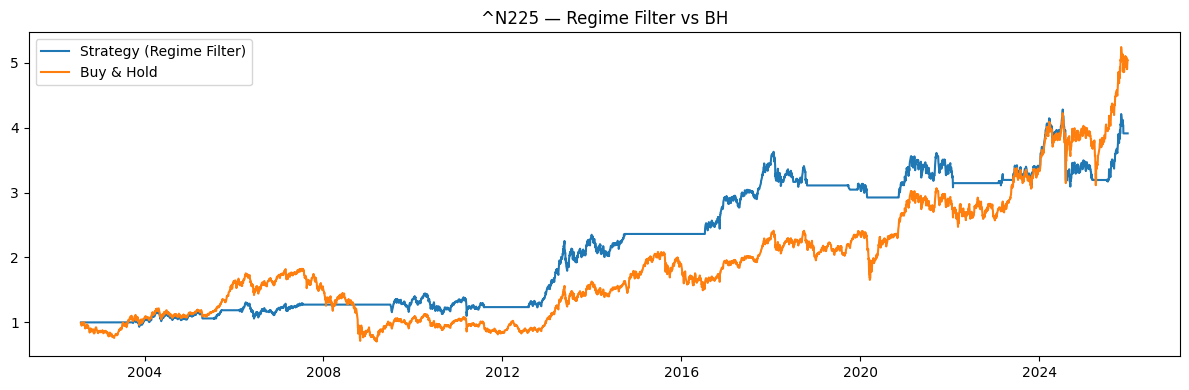

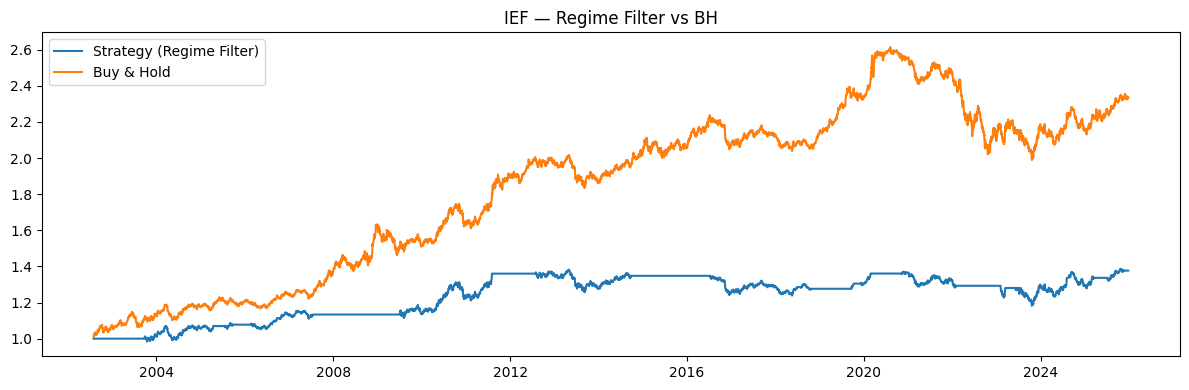

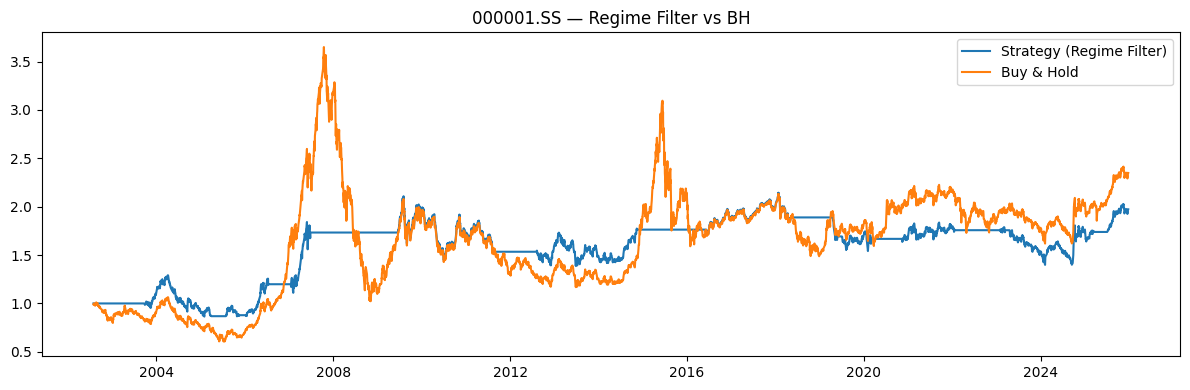

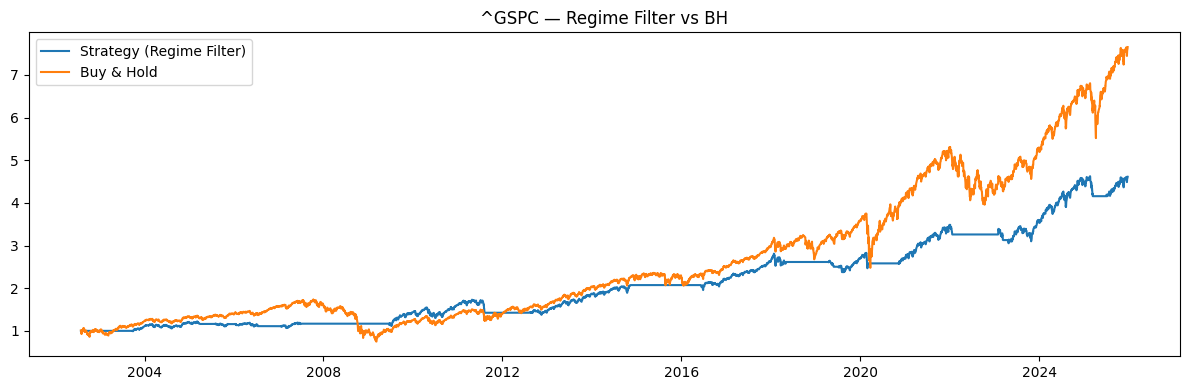

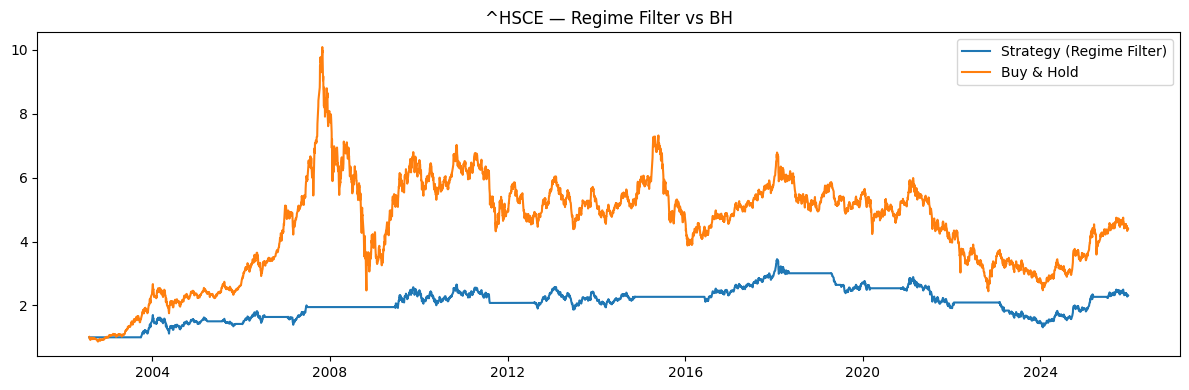

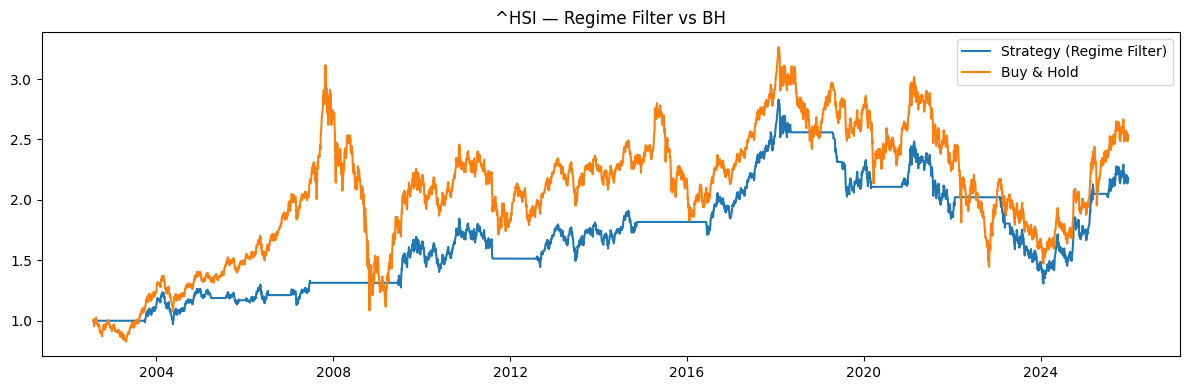

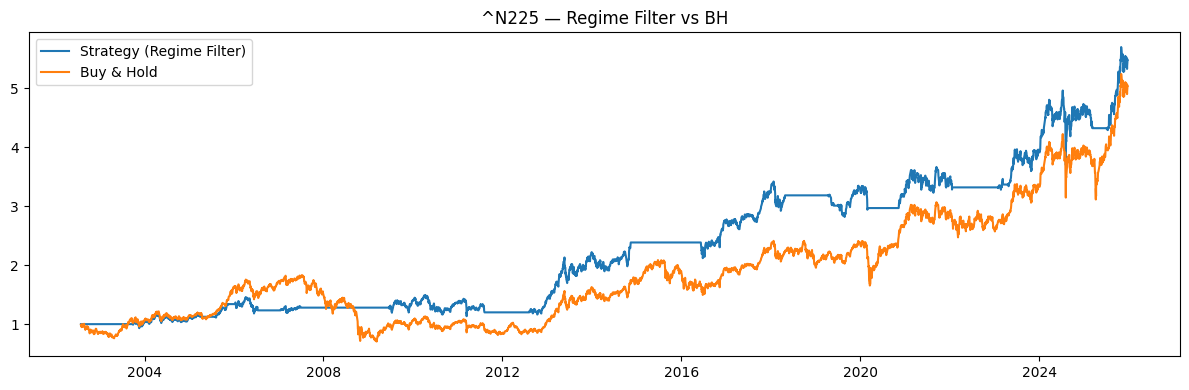

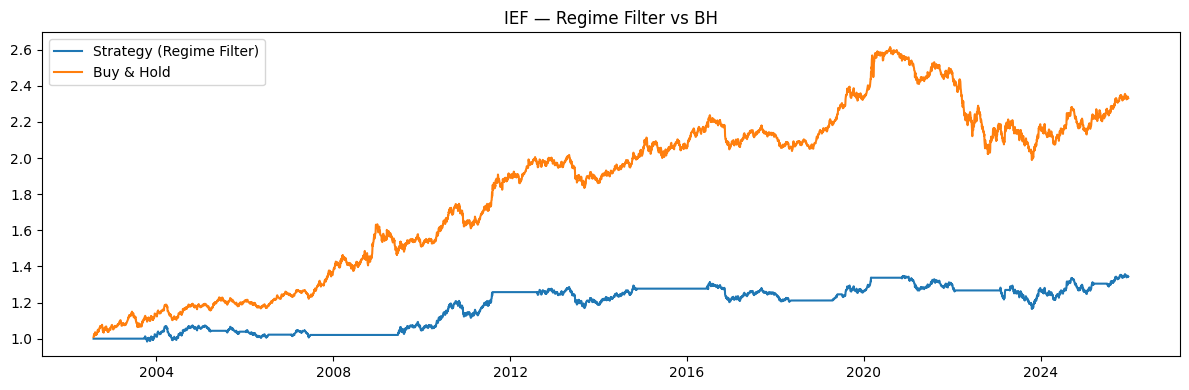

=== HY full period ===
   spread     market    sharpe  bh_sharpe  sharpe_minus_bh    max_dd  \
0  HY_OAS  000001.SS  0.330743   0.175179         0.155564 -0.415743   
5  HY_OAS        IEF  0.330358   0.586820        -0.256462 -0.144757   
1  HY_OAS      ^GSPC  0.734781   0.526707         0.208073 -0.179983   
2  HY_OAS      ^HSCE  0.364963   0.249216         0.115747 -0.624494   
3  HY_OAS       ^HSI  0.423553   0.193150         0.230403 -0.530049   
4  HY_OAS      ^N225  0.445603   0.341985         0.103618 -0.277418   

   pct_in_market  
0       0.569598  
5       0.569598  
1       0.569598  
2       0.569598  
3       0.569598  
4       0.569598  

=== IG full period ===
       spread     market    sharpe  bh_sharpe  sharpe_minus_bh    max_dd  \
0  IG_BBB_OAS  000001.SS  0.222780   0.175179         0.047601 -0.347440   
5  IG_BBB_OAS        IEF  0.295859   0.586820        -0.290961 -0.135739   
1  IG_BBB_OAS      ^GSPC  0.749675   0.526707         0.222967 -0.205354   
2  IG_BBB_O

In [21]:

# ============================================================
# Example usage (edit ONLY here)
# ============================================================

# You already have:
# df = ...  # daily prices, DatetimeIndex
# markets = ['SS001','^GSPC','^HSCE','^HSI','^N225']

# You need:
# hy_spread = ...  # pd.Series (monthly/daily), DatetimeIndex, e.g. FRED BAMLH0A0HYM2
# ig_spread = ...  # pd.Series (monthly/daily), DatetimeIndex, e.g. FRED BAMLC0A4CBBB

# Example:

from pandas_datareader import data as pdr
import datetime as dt

start = dt.datetime(1995, 1, 1)
end   = dt.datetime.today()

hy_spread = pdr.DataReader("BAMLH0A0HYM2", "fred", start, end)["BAMLH0A0HYM2"]
ig_spread = pdr.DataReader("BAMLC0A4CBBB", "fred", start, end)["BAMLC0A4CBBB"]


out = run_hy_ig_credit_regime_tests(
    df=df,
    markets=markets,
    hy_spread=hy_spread,
    ig_spread=ig_spread,
    z_window=252,
    upper=0.5,
    lower=-0.5,
    plot=True,
)

print("=== HY full period ===")
print(out["HY_full"][["spread","market","sharpe","bh_sharpe","sharpe_minus_bh","max_dd","pct_in_market"]]
      .sort_values(["market"]))

print("\n=== IG full period ===")
print(out["IG_full"][["spread","market","sharpe","bh_sharpe","sharpe_minus_bh","max_dd","pct_in_market"]]
      .sort_values(["market"]))

print("\n=== Subsample robustness (HY) ===")
print(out["HY_sub"][["period","spread","market","sharpe","bh_sharpe","sharpe_minus_bh","max_dd","pct_in_market"]]
      .sort_values(["period","market"]))

print("\n=== Subsample robustness (IG) ===")
print(out["IG_sub"][["period","spread","market","sharpe","bh_sharpe","sharpe_minus_bh","max_dd","pct_in_market"]]
      .sort_values(["period","market"]))

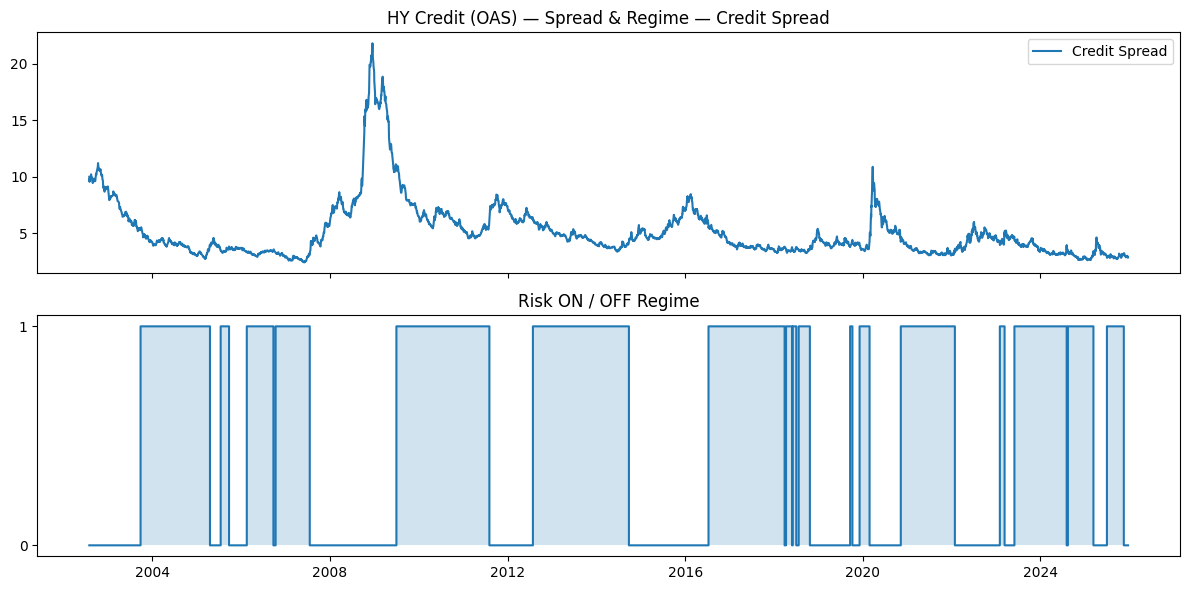

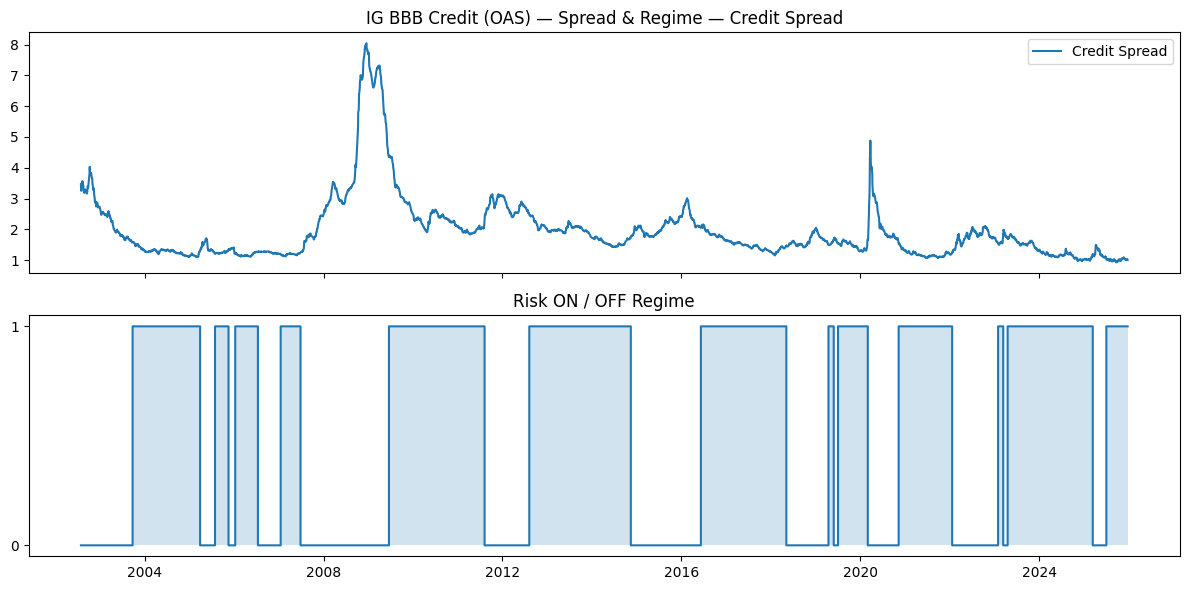

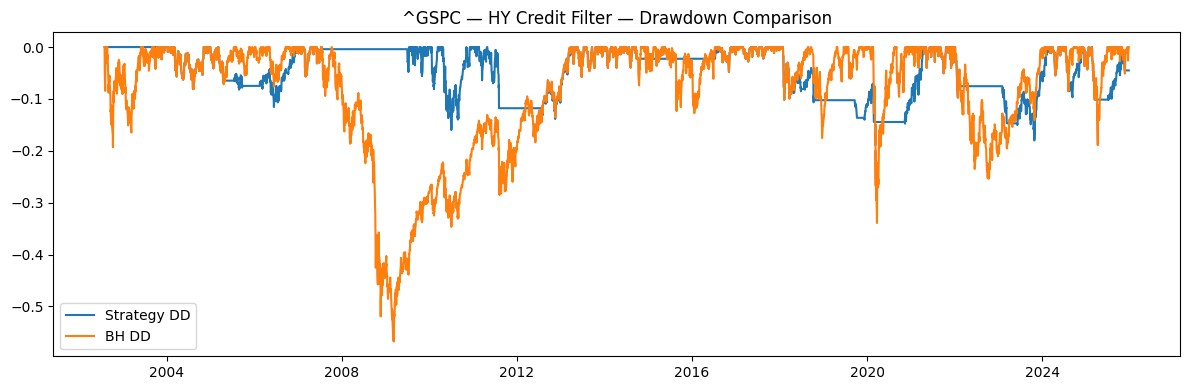

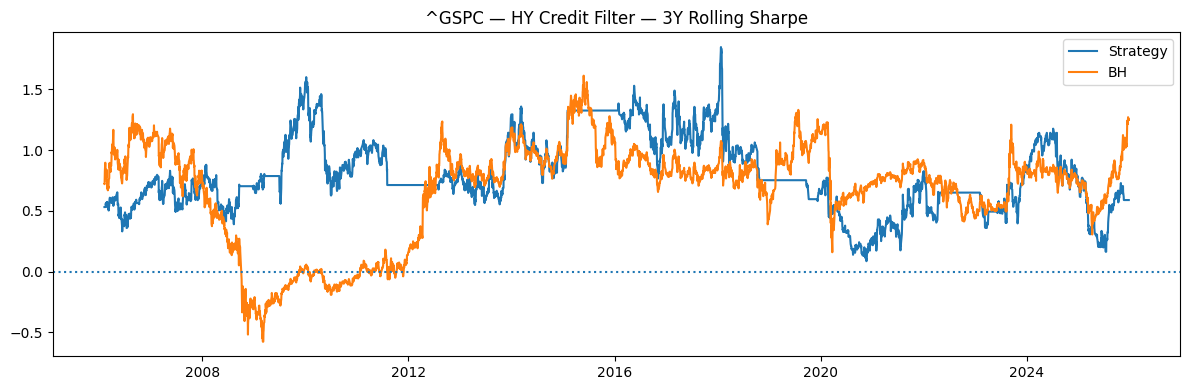

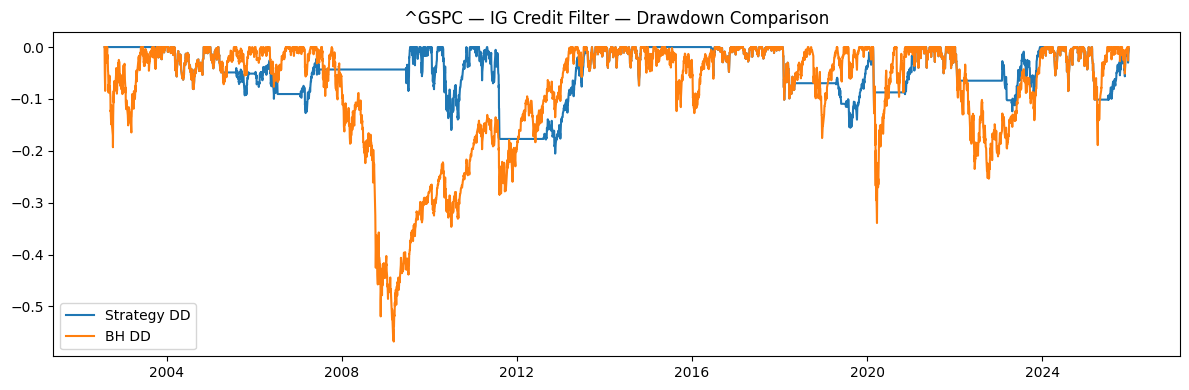

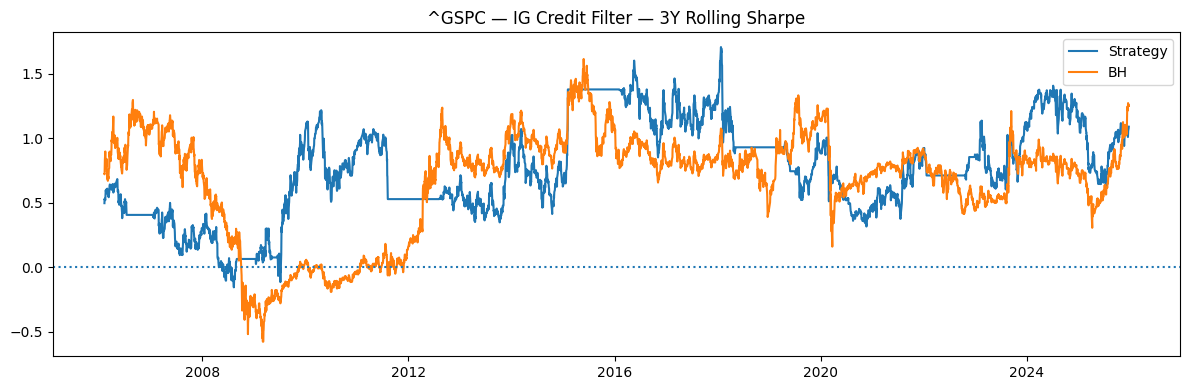

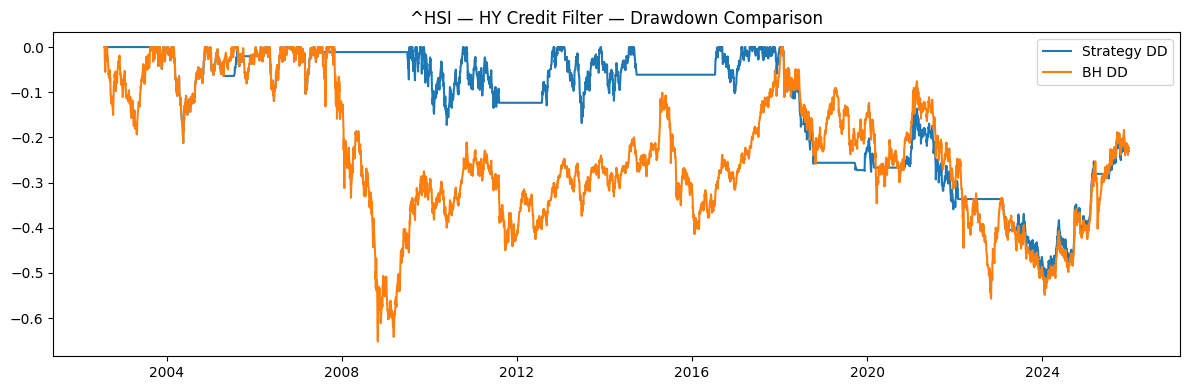

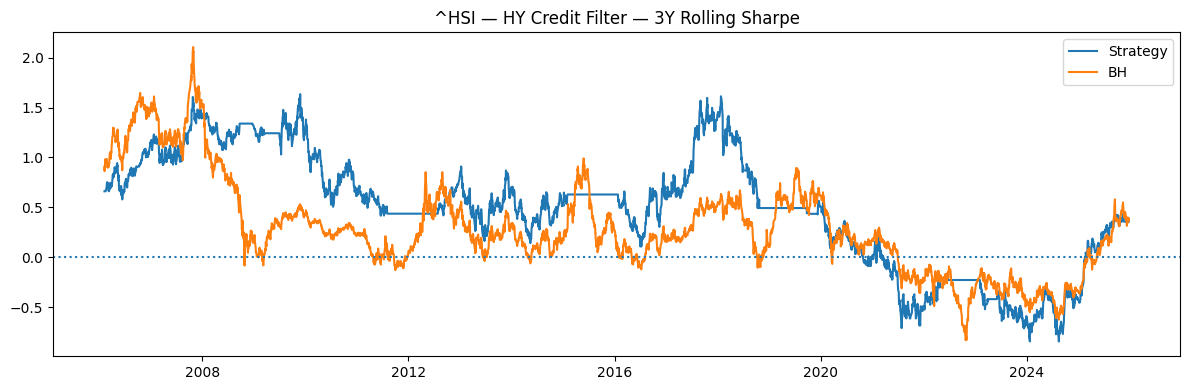

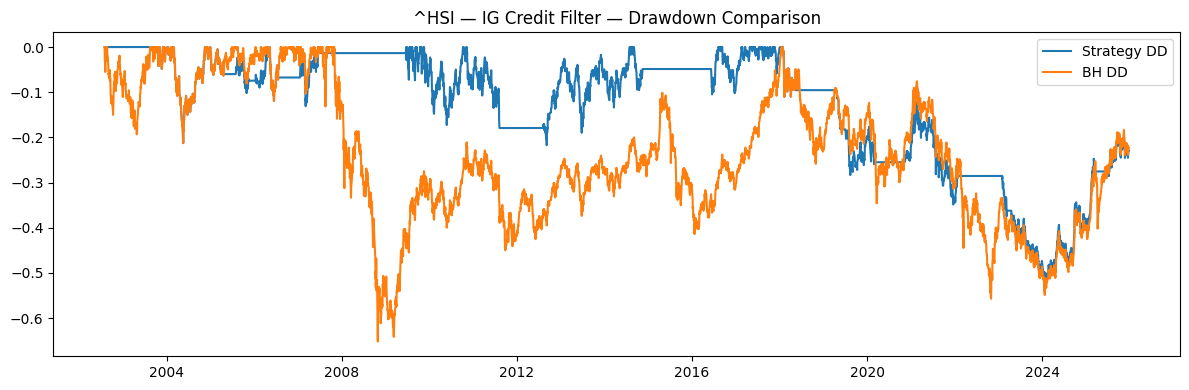

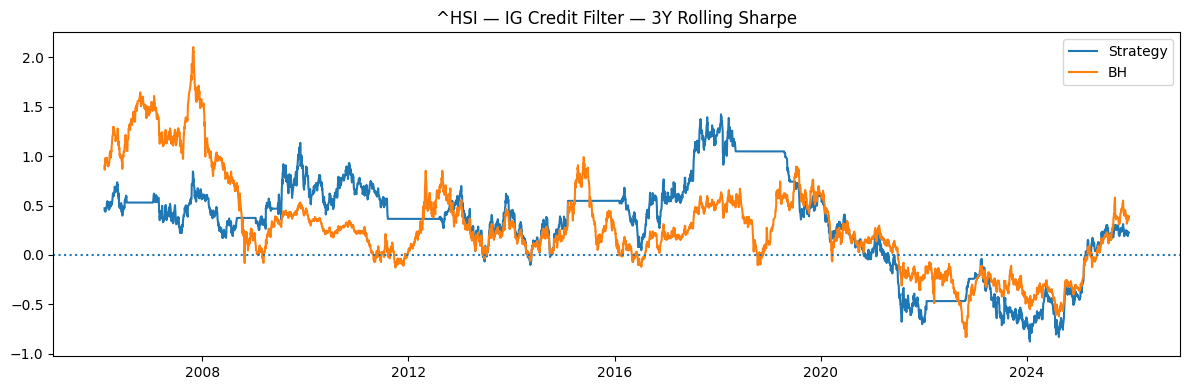

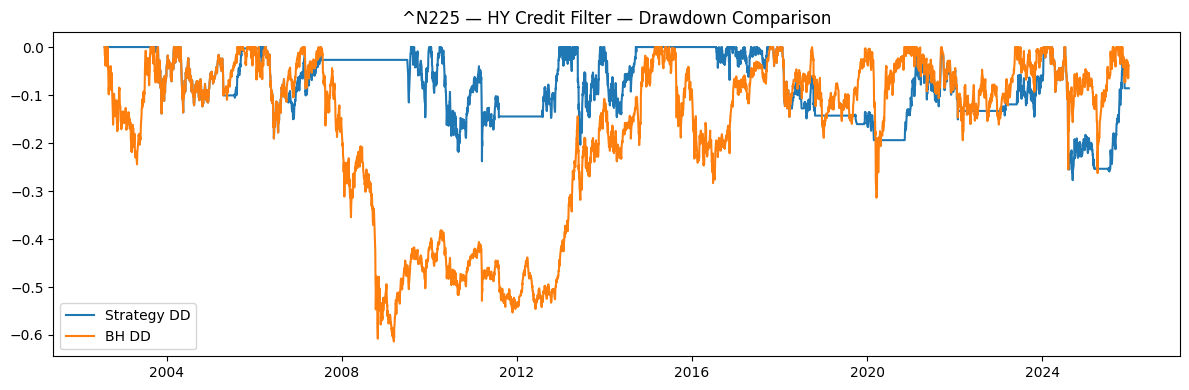

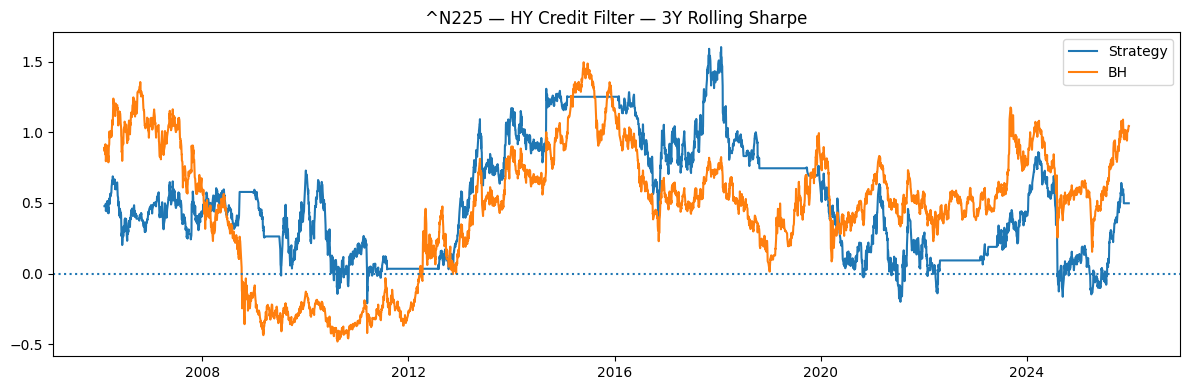

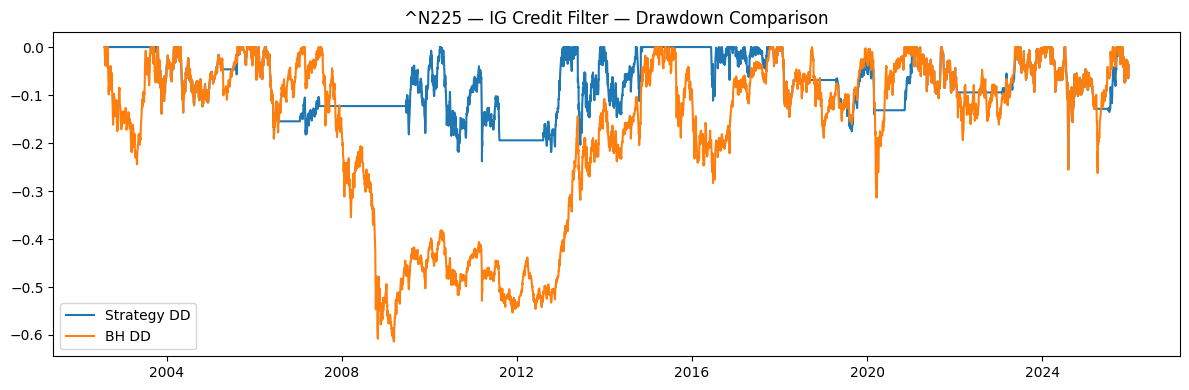

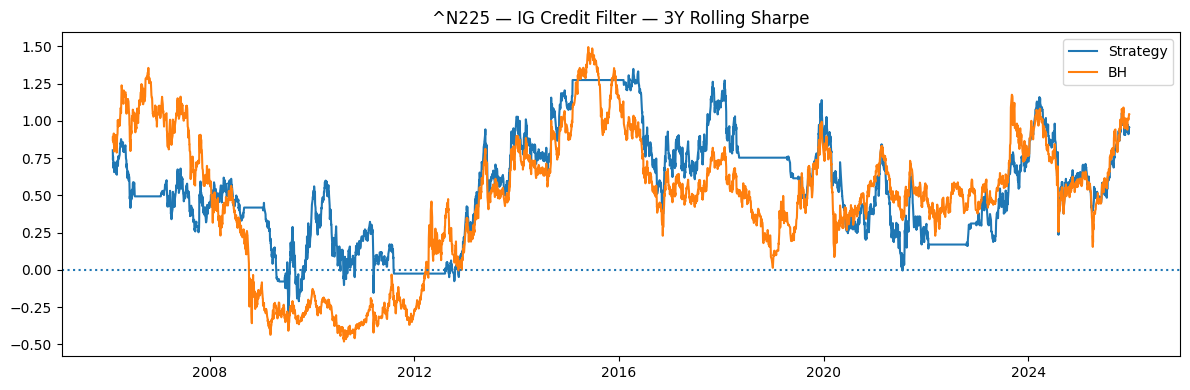

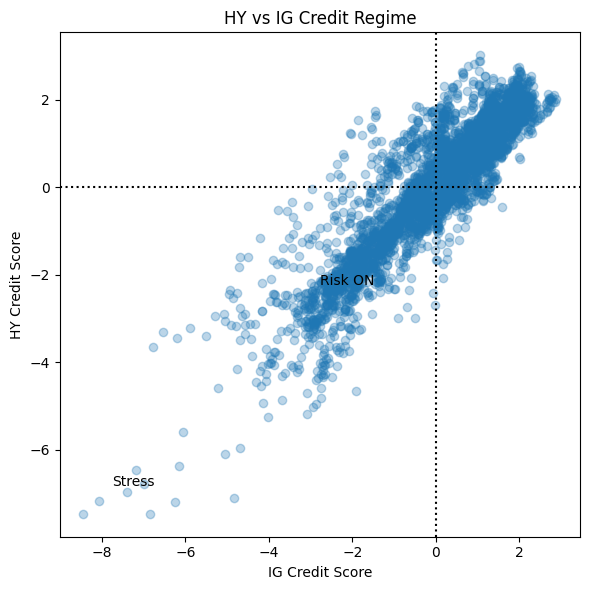

In [22]:
def plot_credit_regime(spread, regime, title):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    ax[0].plot(spread.index, spread, label="Credit Spread")
    ax[0].set_title(f"{title} — Credit Spread")
    ax[0].legend()

    ax[1].plot(regime.index, regime, drawstyle="steps-post")
    ax[1].fill_between(regime.index, 0, 1, where=regime==1, alpha=0.2)
    ax[1].set_title("Risk ON / OFF Regime")
    ax[1].set_yticks([0, 1])

    plt.tight_layout()
    plt.show()

# def plot_equity_curve(bt, market):
#     eq_strat = (1 + bt["strategy_ret"]).cumprod()
#     eq_bh = (1 + bt["bh_ret"]).cumprod()
# 
#     plt.figure(figsize=(12, 4))
#     plt.plot(eq_strat, label="Strategy")
#     plt.plot(eq_bh, label="Buy & Hold")
#     plt.title(f"{market} — Strategy vs BH")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

def plot_drawdown(bt, market):
    eq_s = (1 + bt["strategy_ret"]).cumprod()
    eq_b = (1 + bt["bh_ret"]).cumprod()

    dd_s = eq_s / eq_s.cummax() - 1
    dd_b = eq_b / eq_b.cummax() - 1

    plt.figure(figsize=(12, 4))
    plt.plot(dd_s, label="Strategy DD")
    plt.plot(dd_b, label="BH DD")
    plt.title(f"{market} — Drawdown Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_rolling_sharpe(bt, market, window=756):
    rs = rolling_sharpe(bt["strategy_ret"], window)
    rb = rolling_sharpe(bt["bh_ret"], window)

    plt.figure(figsize=(12, 4))
    plt.plot(rs, label="Strategy")
    plt.plot(rb, label="BH")
    plt.axhline(0, linestyle=":")
    plt.title(f"{market} — {window//252}Y Rolling Sharpe")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_hy_ig_quadrant(hy_score, ig_score):
    plt.figure(figsize=(6, 6))
    plt.scatter(ig_score, hy_score, alpha=0.3)
    plt.axhline(0, color="k", linestyle=":")
    plt.axvline(0, color="k", linestyle=":")

    plt.xlabel("IG Credit Score")
    plt.ylabel("HY Credit Score")
    plt.title("HY vs IG Credit Regime")

    plt.text(0.5, 0.5, "Risk ON", transform=plt.gca().transAxes)
    plt.text(0.1, 0.1, "Stress", transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()
    

    
# ============================================================
# ADD PLOTS (paste below your prints)
# ============================================================

# ---- 0) Align spreads to df daily index (so plots match your market dates)
hy_daily = hy_spread.reindex(df.index).ffill()
ig_daily = ig_spread.reindex(df.index).ffill()

# ---- 1) Rebuild scores + regimes (same params as your test)
hy_score = build_credit_score(hy_daily, z_window=252)
ig_score = build_credit_score(ig_daily, z_window=252)

hy_regime = hysteresis_regime(hy_score, upper=0.5, lower=-0.5)
ig_regime = hysteresis_regime(ig_score, upper=0.5, lower=-0.5)

# ---- 2) Plot: Credit spread + regime (sanity check)
plot_credit_regime(
    spread=hy_daily,
    regime=hy_regime,
    title="HY Credit (OAS) — Spread & Regime"
)

plot_credit_regime(
    spread=ig_daily,
    regime=ig_regime,
    title="IG BBB Credit (OAS) — Spread & Regime"
)

# ---- 3) Pick 2–3 representative markets to plot (avoid plot spam)
plot_markets = ["^GSPC", "^HSI", "^N225"]  # edit if needed

for m in plot_markets:
    # HY-filter backtest object
    bt_hy, _ = backtest_long_only_filter(df[m], hy_regime)

    # plot_equity_curve(bt=bt_hy, market=f"{m} — HY Credit Filter")
    plot_drawdown(bt=bt_hy, market=f"{m} — HY Credit Filter")
    plot_rolling_sharpe(bt=bt_hy, market=f"{m} — HY Credit Filter", window=756)  # 3y
    # Optional 2y:
    # plot_rolling_sharpe(bt=bt_hy, market=f"{m} — HY Credit Filter", window=504)

    # IG-filter backtest object
    bt_ig, _ = backtest_long_only_filter(df[m], ig_regime)

    # plot_equity_curve(bt=bt_ig, market=f"{m} — IG Credit Filter")
    plot_drawdown(bt=bt_ig, market=f"{m} — IG Credit Filter")
    plot_rolling_sharpe(bt=bt_ig, market=f"{m} — IG Credit Filter", window=756)

# ---- 4) Optional: HY vs IG disagreement quadrant (insight plot)
common_idx = hy_score.dropna().index.intersection(ig_score.dropna().index)
plot_hy_ig_quadrant(
    hy_score=hy_score.loc[common_idx],
    ig_score=ig_score.loc[common_idx]
)